In [1]:
import numpy as np
import pandas as pd

from apyori import apriori
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.font_manager import FontProperties

from datetime import datetime
import en_nlp_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-29 16:35:21.750378


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

df_review:
source                       0
hotel_id                     0
hotel_name                   0
country                      0
group_name                   0
room_type                    0
stay_length                  0
stay_date                    0
review_score                 0
review_score_category        0
sentiment                    0
review_date                  0
review_title                 1
review                       0
review_cleaned_v1            0
review_cleaned_v2            0
ADJ                       4627
ADV                      19212
NOUN                      4680
VERB                     14715
PROPN                    24789
DET                      38189
NUM                      38187
dtype: int64
Total rows in df_review: 39602 



## 1) Association Rule Mining

### a) Helper functions

In [4]:
# Function to convert the input value of a string type to a list of words
def process_all_words(value):
    if isinstance(value, str):
        return value.split()
    return []


# Function to discover association rules between item sets in a data set
# and to represent these rules as a graphical network for visualization
def find_association_rules(target_text, min_support=0.01, min_confidence=0.3, min_lift=3, min_length=2):
    
    # Process target_text: split each string into a list of words
    text = target_text.apply(process_all_words)
    text = [x for x in text if x != []]  # Remove empty lists
    
    # Find association rules using Apriori algorithm
    association_rules = apriori(text, min_support=min_support, min_confidence=min_confidence, 
                                min_lift=min_lift, min_length=min_length)
    association_results = list(association_rules)
    
    # Initialize a directed graph
    G = nx.DiGraph()
    
    # Summarize association rules and add edges to the graph
    rules_summary = [{
        "antecedent": list(item[2][0][0]),
        "consequent": list(item[2][0][1]),
        "support": round(item[1], 4),
        "confidence": round(item[2][0][2], 4),
        "lift": round(item[2][0][3], 4),
    } for item in association_results]
    
    print(f"Success. {len(rules_summary)} rules found.")
    print("========================================")
    
    # Print and add edges to the graph
    for rule in rules_summary:
        print(f"Rule: {rule['antecedent']} => {rule['consequent']}")
        print("Support: " + str(rule["support"]))
        print("Confidence: " + str(rule["confidence"]))
        print("Lift: " + str(rule["lift"]))
        print("----------------------------------------")
        
        # Add edges to the graph
        for ant in rule["antecedent"]:
            for con in rule["consequent"]:
                G.add_edge(ant, con, weight=rule["lift"], support=rule["support"], confidence=rule["confidence"])

    # Check if there are any edges to plot
    edges = G.edges(data=True)
    if not edges:
        print("No edges to plot. Exiting visualization.")
        return
    
    # Create a custom colormap
    colors = plt.cm.Blues(np.linspace(0.5, 1, 256))
    new_cmap = LinearSegmentedColormap.from_list("new_blues", colors)
    
    # Draw the network graph
    pos = nx.spring_layout(G, k=1, iterations=15)  # Adjust layout parameters for a more compact graph
    plt.figure(figsize=(12, 12))  # Increase figure size for better visibility
    
    # Node color and size
    node_color = "skyblue"
    node_size = 3000
    
    # Edge width and color
    edge_color = [d["weight"] for (u, v, d) in edges]
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    
    # Function to shorten edges to prevent overlap with nodes
    def shorten_edge(pos, src, dst, shrink_factor=0.1):
        """Shorten edges to prevent overlap with nodes"""
        x1, y1 = pos[src]
        x2, y2 = pos[dst]
        new_x2 = x1 + (x2 - x1) * (1 - shrink_factor)
        new_y2 = y1 + (y2 - y1) * (1 - shrink_factor)
        return (x1, y1), (new_x2, new_y2)
    
    new_edges = []
    for src, dst, data in edges:
        new_edges.append((*shorten_edge(pos, src, dst), data))
    
    # Draw edges with shortened positions
    for ((x1, y1), (x2, y2), data) in new_edges:
        plt.arrow(x1, y1, x2 - x1, y2 - y1, color=new_cmap(Normalize(vmin=min(edge_color), 
                                                                     vmax=max(edge_color))(data["weight"])),
            alpha=0.8, head_width=0.05, head_length=0.1, length_includes_head=True, width=0.01)
        # Show lift value at the midpoint of the edge
        plt.text((x1 + x2) / 2, (y1 + y2) / 2, f"{data['weight']:.2f}", fontsize=10, 
                 horizontalalignment="center", verticalalignment="center")

    # Draw labels with specified font
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=12, horizontalalignment="center", verticalalignment="center")
    
    # Adjust color mapping for better visibility of the lightest color
    norm = Normalize(vmin=min(edge_color), vmax=max(edge_color))
    sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca())
    
    plt.title("Association Rules Network")
    plt.show()

### b) Find association using whole cleaned reviews

Length of df_review: 39602
Length of df_target_text: 39602
Success. 17 rules found.
Rule: ['bottle'] => ['water']
Support: 0.0109
Confidence: 0.8745
Lift: 15.3509
----------------------------------------
Rule: ['buffet'] => ['breakfast']
Support: 0.0109
Confidence: 0.834
Lift: 10.276
----------------------------------------
Rule: ['stop'] => ['bus']
Support: 0.028
Confidence: 0.7981
Lift: 14.9444
----------------------------------------
Rule: ['desk'] => ['front']
Support: 0.0184
Confidence: 0.7717
Lift: 22.1287
----------------------------------------
Rule: ['distance'] => ['walk']
Support: 0.033
Confidence: 0.8982
Lift: 9.8208
----------------------------------------
Rule: ['highly'] => ['recommend']
Support: 0.0161
Confidence: 0.9165
Lift: 14.0251
----------------------------------------
Rule: ['value'] => ['money']
Support: 0.0287
Confidence: 0.7184
Lift: 16.7737
----------------------------------------
Rule: ['swim'] => ['pool']
Support: 0.0146
Confidence: 0.9539
Lift: 17.0929
---

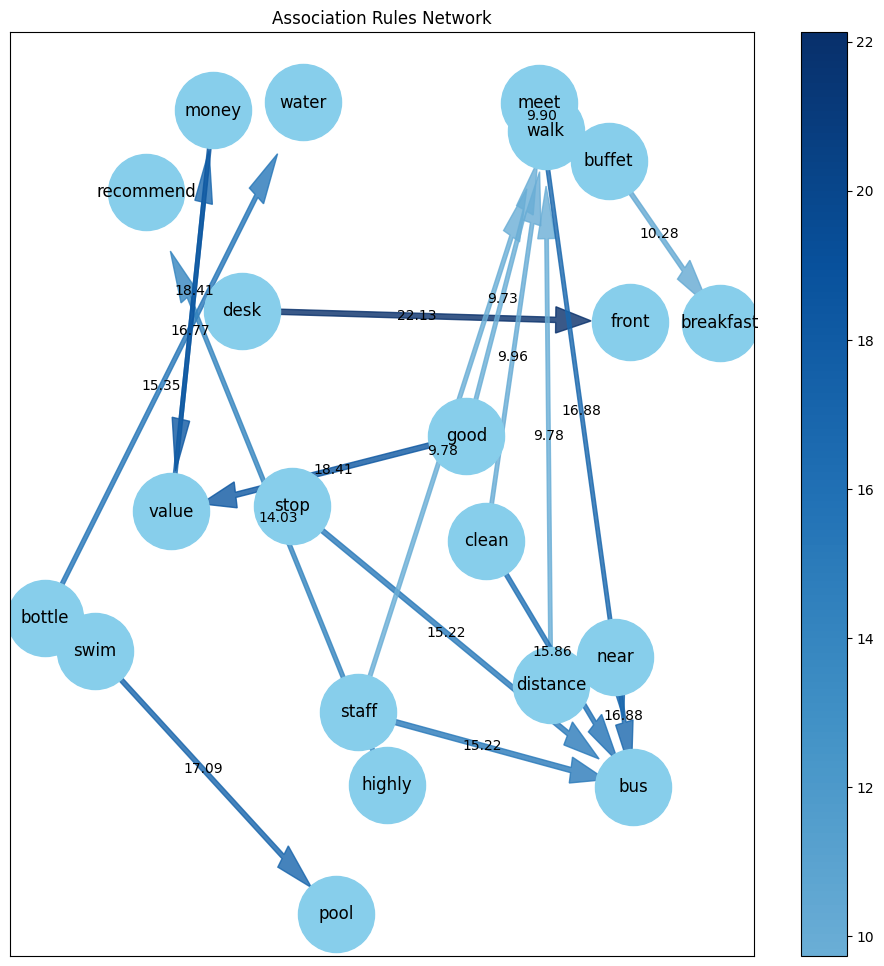

In [5]:
target_text = "review_cleaned_v2"

# Remove rows when target_text is NULL
df_target_text = df_review.dropna(subset=[target_text]).reset_index(drop=True)
print(f"Length of df_review: {len(df_review)}")
print(f"Length of df_target_text: {len(df_target_text)}")

# Find association
find_association_rules(df_target_text[target_text], 0.01, 0.7, 5)

### c) Find association using words by POS tagging

Length of ADJ: 34975
Success. 20 rules found.
Rule: ['bare'] => ['long']
Support: 0.0012
Confidence: 0.4667
Lift: 25.3442
----------------------------------------
Rule: ['male'] => ['female']
Support: 0.0008
Confidence: 0.4308
Lift: 111.6011
----------------------------------------
Rule: ['sleeper'] => ['light']
Support: 0.0006
Confidence: 0.5833
Lift: 73.1257
----------------------------------------
Rule: ['cold', 'available'] => ['hot']
Support: 0.0005
Confidence: 0.5806
Lift: 25.6739
----------------------------------------
Rule: ['cold', 'enough'] => ['hot']
Support: 0.0005
Confidence: 0.439
Lift: 19.412
----------------------------------------
Rule: ['cold', 'overall'] => ['hot']
Support: 0.0006
Confidence: 0.44
Lift: 19.4551
----------------------------------------
Rule: ['spacious', 'cold'] => ['hot']
Support: 0.0005
Confidence: 0.5
Lift: 22.1081
----------------------------------------
Rule: ['comfortable', 'public'] => ['easy']
Support: 0.0008
Confidence: 0.4531
Lift: 12.5579


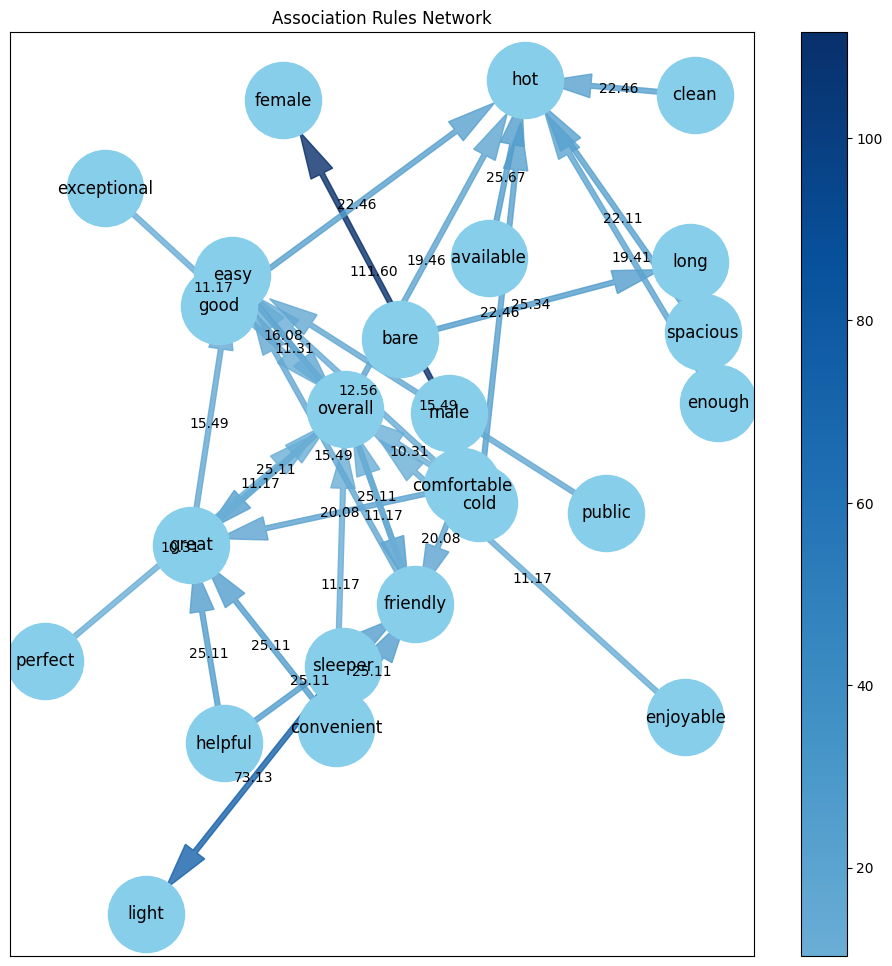

In [6]:
# Remove rows when "ADJ" is NULL
df_tag = df_review.dropna(subset=["ADJ"]).reset_index(drop=True)
print(f"Length of ADJ: {len(df_tag)}")

# Find association
find_association_rules(df_tag["ADJ"], 0.0005, 0.4, 10)

Length of ADV: 20390
Success. 15 rules found.
Rule: ['home'] => ['away']
Support: 0.0009
Confidence: 0.3725
Lift: 8.1945
----------------------------------------
Rule: ['forth'] => ['back']
Support: 0.0006
Confidence: 0.8125
Lift: 12.1905
----------------------------------------
Rule: ['bit'] => ['far']
Support: 0.0015
Confidence: 0.5455
Lift: 12.2893
----------------------------------------
Rule: ['somewhere'] => ['else']
Support: 0.0021
Confidence: 0.4565
Lift: 32.5471
----------------------------------------
Rule: ['never', 'already'] => ['even']
Support: 0.0006
Confidence: 0.6667
Lift: 6.6083
----------------------------------------
Rule: ['first', 'already'] => ['still']
Support: 0.0006
Confidence: 0.4
Lift: 6.8423
----------------------------------------
Rule: ['finally', 'also'] => ['never']
Support: 0.0005
Confidence: 0.3438
Lift: 12.8371
----------------------------------------
Rule: ['still', 'right'] => ['away']
Support: 0.0006
Confidence: 0.3429
Lift: 7.5414
---------------

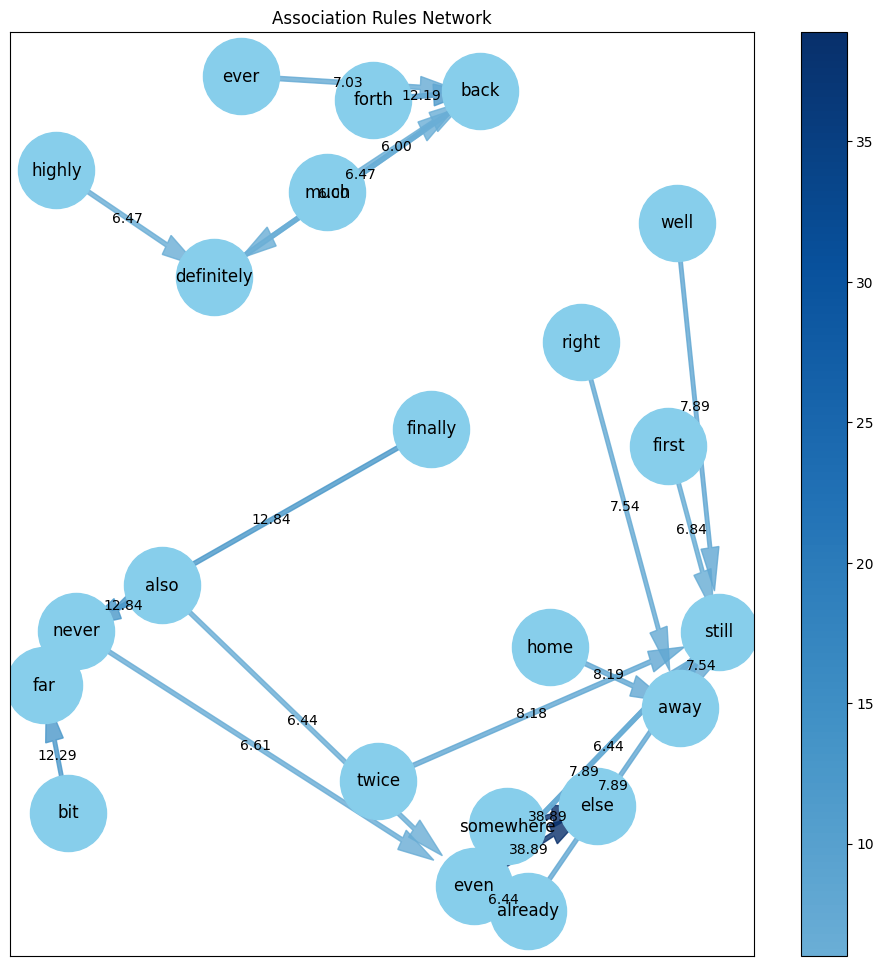

In [7]:
# Remove rows when "ADV" is NULL
df_tag = df_review.dropna(subset=["ADV"]).reset_index(drop=True)
print(f"Length of ADV: {len(df_tag)}")

# Find association
find_association_rules(df_tag["ADV"], 0.0005, 0.3, 6)

Length of NOUN: 34922
Success. 13 rules found.
Rule: ['bottle'] => ['water']
Support: 0.0115
Confidence: 0.8799
Lift: 13.9231
----------------------------------------
Rule: ['bus'] => ['station']
Support: 0.0266
Confidence: 0.4406
Lift: 4.9227
----------------------------------------
Rule: ['stop'] => ['bus']
Support: 0.0166
Confidence: 0.8324
Lift: 13.8026
----------------------------------------
Rule: ['distance'] => ['walk']
Support: 0.0328
Confidence: 0.7905
Lift: 10.7582
----------------------------------------
Rule: ['option'] => ['food']
Support: 0.0101
Confidence: 0.3621
Lift: 4.3093
----------------------------------------
Rule: ['meet'] => ['station']
Support: 0.0425
Confidence: 0.5432
Lift: 6.0682
----------------------------------------
Rule: ['minute'] => ['walk']
Support: 0.0134
Confidence: 0.488
Lift: 6.6412
----------------------------------------
Rule: ['money'] => ['value']
Support: 0.0308
Confidence: 0.6361
Lift: 14.6734
----------------------------------------
Rule:

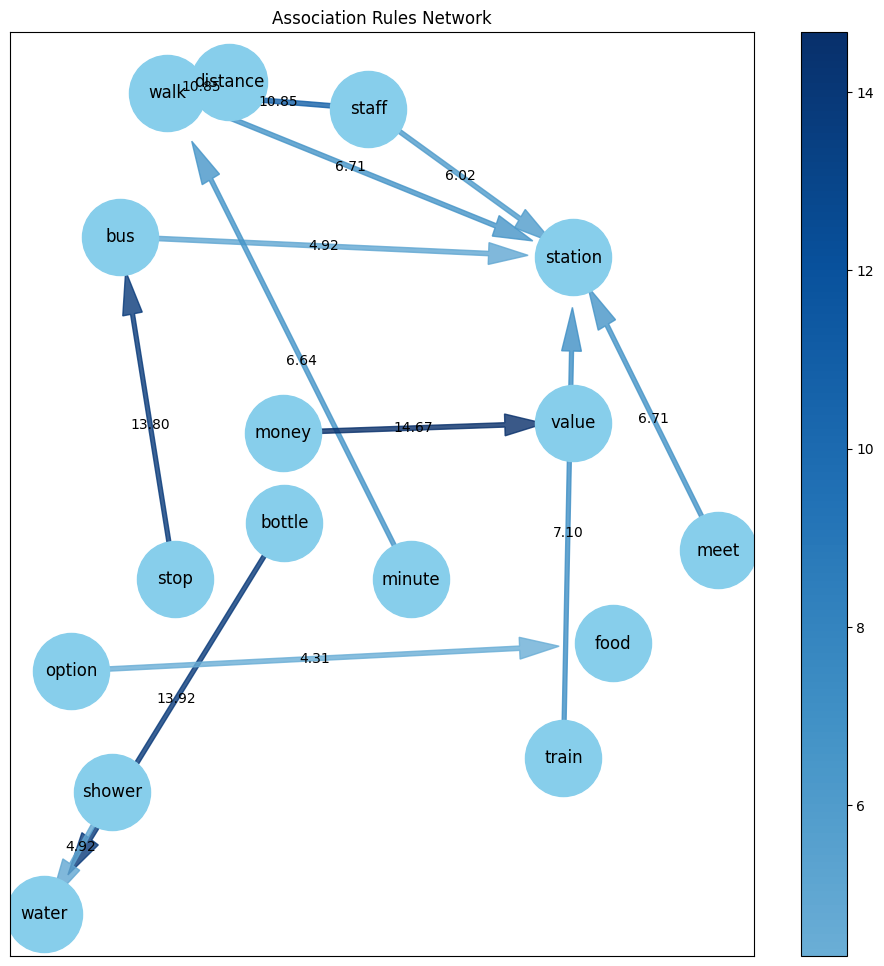

In [8]:
# Remove rows when "NOUN" is NULL
df_tag = df_review.dropna(subset=["NOUN"]).reset_index(drop=True)
print(f"Length of NOUN: {len(df_tag)}")

# Find association
find_association_rules(df_tag["NOUN"])

Length of VERB: 24887
Success. 21 rules found.
Rule: ['topnotch'] => ['recommend']
Support: 0.0006
Confidence: 0.8235
Lift: 10.1764
----------------------------------------
Rule: ['ask', 'pick'] => ['say']
Support: 0.0005
Confidence: 0.7647
Lift: 20.2245
----------------------------------------
Rule: ['come', 'insist'] => ['say']
Support: 0.0005
Confidence: 0.619
Lift: 16.3722
----------------------------------------
Rule: ['ask', 'call', 'come'] => ['say']
Support: 0.0006
Confidence: 0.7143
Lift: 18.891
----------------------------------------
Rule: ['ask', 'check', 'want'] => ['say']
Support: 0.0008
Confidence: 0.6176
Lift: 16.3352
----------------------------------------
Rule: ['ask', 'come', 'tell'] => ['say']
Support: 0.001
Confidence: 0.6047
Lift: 15.9914
----------------------------------------
Rule: ['come', 'take', 'wait'] => ['ask']
Support: 0.0007
Confidence: 0.6
Lift: 15.175
----------------------------------------
Rule: ['ask', 'wait', 'give'] => ['say']
Support: 0.0006
Co

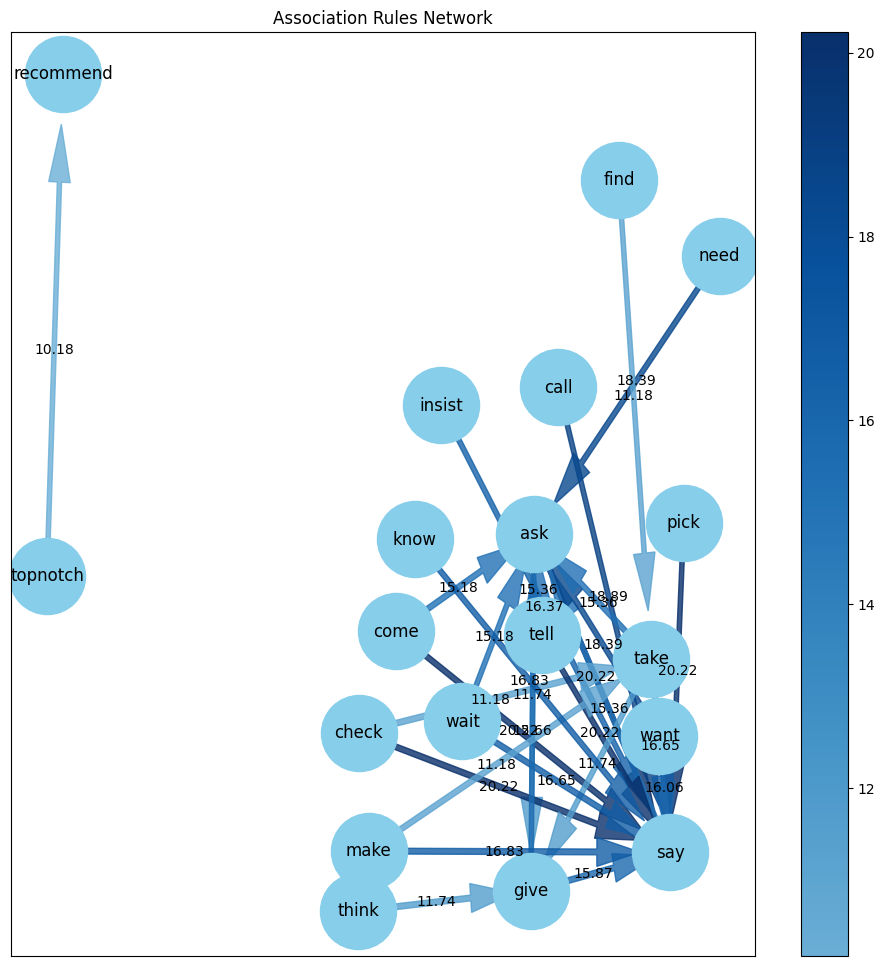

In [9]:
# Remove rows when "VERB" is NULL
df_tag = df_review.dropna(subset=["VERB"]).reset_index(drop=True)
print(f"Length of VERB: {len(df_tag)}")

# Find association
find_association_rules(df_tag["VERB"], 0.0005, 0.6, 10)

Length of PROPN: 14813
Success. 16 rules found.
Rule: ['sand'] => ['bay']
Support: 0.0038
Confidence: 0.9825
Lift: 45.196
----------------------------------------
Rule: ['junction'] => ['boris']
Support: 0.0061
Confidence: 0.9785
Lift: 25.4735
----------------------------------------
Rule: ['buena'] => ['vista']
Support: 0.0012
Confidence: 1.0
Lift: 529.0357
----------------------------------------
Rule: ['rustle'] => ['bustle']
Support: 0.0011
Confidence: 0.85
Lift: 340.2986
----------------------------------------
Rule: ['town'] => ['china']
Support: 0.0059
Confidence: 0.9667
Lift: 79.5513
----------------------------------------
Rule: ['clark'] => ['quay']
Support: 0.0012
Confidence: 0.8182
Lift: 52.9246
----------------------------------------
Rule: ['clarke'] => ['quay']
Support: 0.0064
Confidence: 0.9223
Lift: 59.6615
----------------------------------------
Rule: ['sand'] => ['marina']
Support: 0.0038
Confidence: 1.0
Lift: 46.0031
----------------------------------------
Rule: [

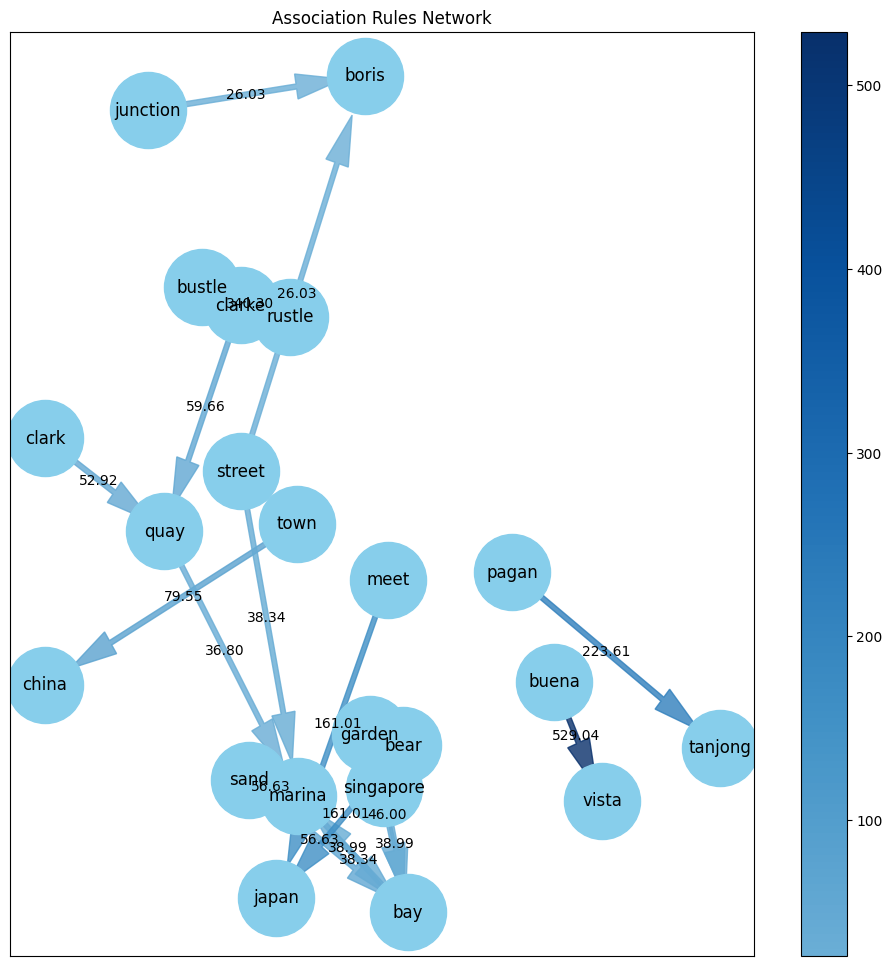

In [10]:
# Remove rows when "PROPN" is NULL
df_tag = df_review.dropna(subset=["PROPN"]).reset_index(drop=True)
print(f"Length of PROPN: {len(df_tag)}")

# Find association
find_association_rules(df_tag["PROPN"], 0.001, 0.8, 20)

Length of DET: 1413
Success. 12 rules found.
Rule: ['anywhere'] => ['stationthe']
Support: 0.0007
Confidence: 0.5
Lift: 353.25
----------------------------------------
Rule: ['bunkthe'] => ['flodedthe']
Support: 0.0007
Confidence: 1.0
Lift: 1413.0
----------------------------------------
Rule: ['bunkthe'] => ['toiletsthis']
Support: 0.0007
Confidence: 1.0
Lift: 1413.0
----------------------------------------
Rule: ['experiencedthe'] => ['informationthe']
Support: 0.0007
Confidence: 1.0
Lift: 1413.0
----------------------------------------
Rule: ['familiesthe'] => ['singaporethe']
Support: 0.0007
Confidence: 1.0
Lift: 471.0
----------------------------------------
Rule: ['flodedthe'] => ['toiletsthis']
Support: 0.0007
Confidence: 1.0
Lift: 1413.0
----------------------------------------
Rule: ['hotelthe'] => ['th']
Support: 0.0007
Confidence: 1.0
Lift: 706.5
----------------------------------------
Rule: ['bunkthe'] => ['every', 'flodedthe']
Support: 0.0007
Confidence: 1.0
Lift: 1413.0


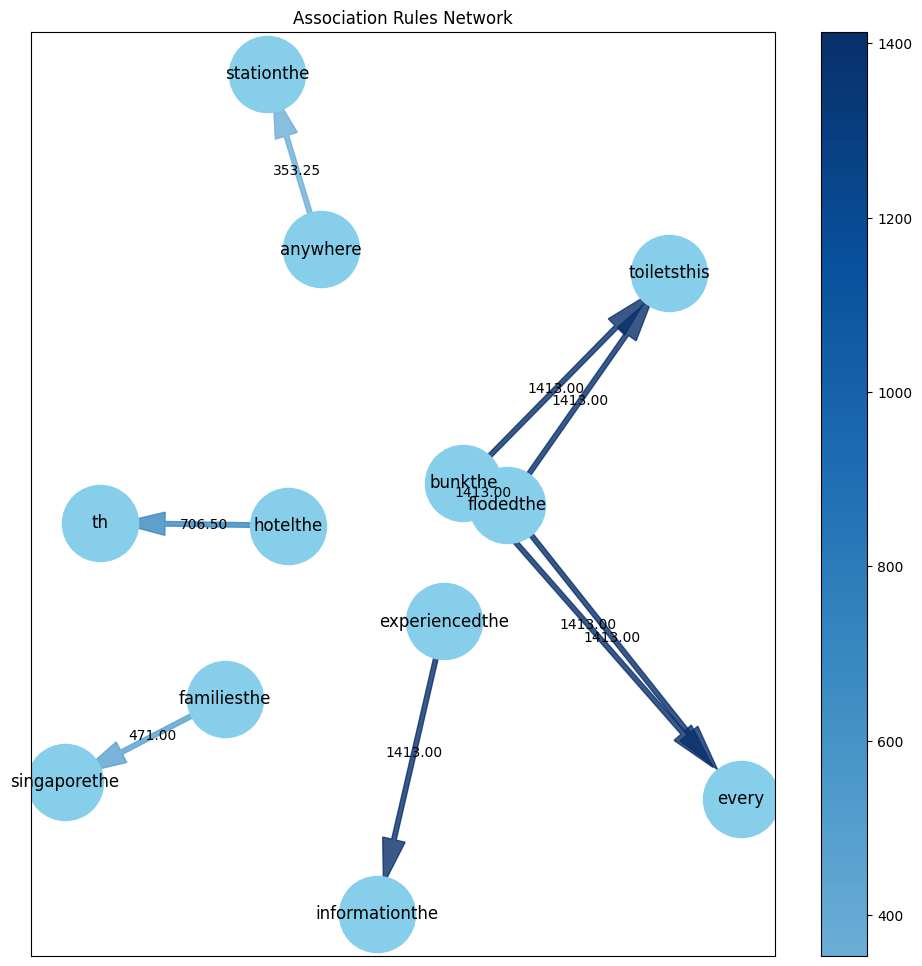

In [11]:
# Remove rows when "DET" is NULL
df_tag = df_review.dropna(subset=["DET"]).reset_index(drop=True)
print(f"Length of DET: {len(df_tag)}")

# Find association
find_association_rules(df_tag["DET"], 0.0005, 0.5, 20)

Length of NUM: 1415
Success. 4 rules found.
Rule: ['eight'] => ['three', 'two']
Support: 0.0007
Confidence: 1.0
Lift: 47.1667
----------------------------------------
Rule: ['two', 'seven'] => ['eleven']
Support: 0.0007
Confidence: 1.0
Lift: 10.8015
----------------------------------------
Rule: ['two', 'ten'] => ['four']
Support: 0.0014
Confidence: 1.0
Lift: 13.7379
----------------------------------------
Rule: ['five', 'six'] => ['three', 'two']
Support: 0.0007
Confidence: 1.0
Lift: 47.1667
----------------------------------------


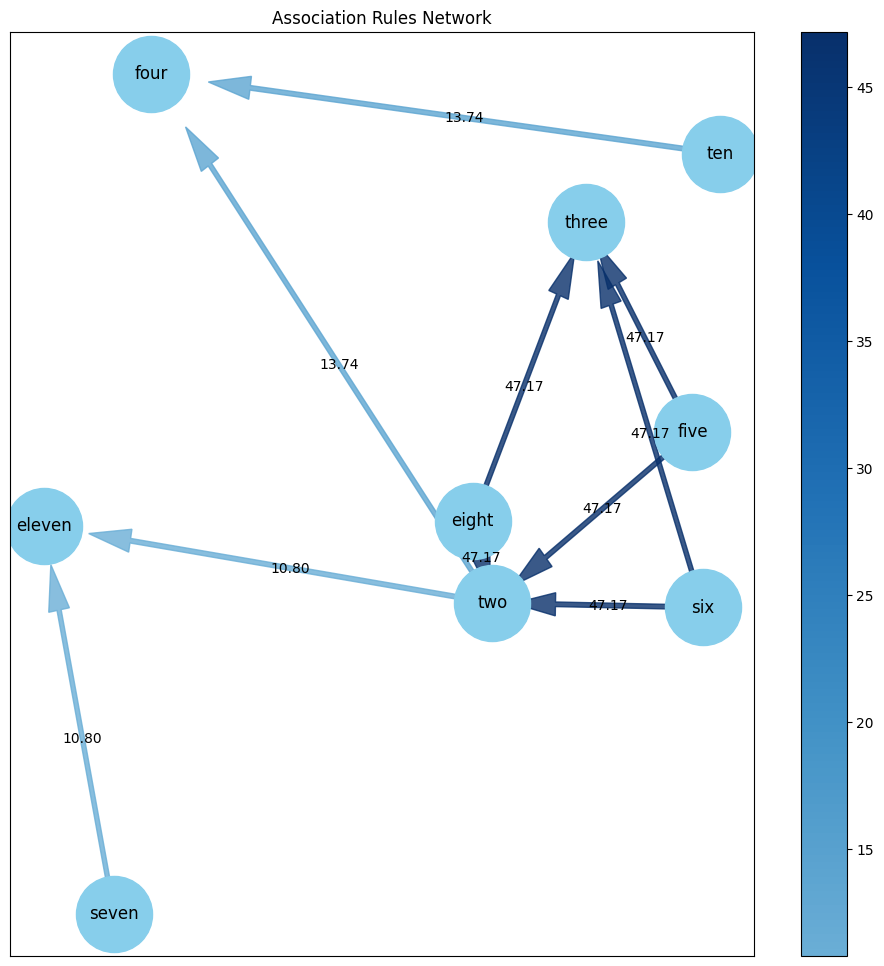

In [12]:
# Remove rows when "NUM" is NULL
df_tag = df_review.dropna(subset=["NUM"]).reset_index(drop=True)
print(f"Length of NUM: {len(df_tag)}")

# Find association
find_association_rules(df_tag["NUM"], 0.0005, 0.5, 10)

In [13]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-29 16:36:04.115495
Text processing spent 0:00:42.365117
